In [233]:
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import numpy as np

# --- 기본 설정 ---
resolution = 50
tpml = 0.5
boundary_layers = [mp.PML(thickness=tpml, direction=mp.Y)]
lambda_min = 0.4
lambda_max = 0.7

fmax = 1/lambda_min
fmin = 1/lambda_max

fcen = 0.5*(fmin+fmax)
df = fmax-fmin

# --- 재료 ---
SiO2  = mp.Medium(index=1.47)
air   = mp.Medium(index=1.0)
gan   = mp.Medium(index=2.48)
Al2O3 = mp.Medium(index=1.78)

# --- 기하 파라미터 ---
ag_bottom_x = 1.00
ag_bottom_y = 0.10
gan_y       = 1.00
SiO2_x      = 0.07
Al2O3_x     = 0.07
ag_side_x   = 0.10

side_stack_y = ag_bottom_y + gan_y          # 1.10
design_region_width  = 1.14
design_region_height = 0.15

# --- 셀 크기 (내부 디바이스 + PML) ---
device_width  = ag_bottom_x + 2*(SiO2_x + Al2O3_x + ag_side_x)
device_height = ag_bottom_y + gan_y + design_region_height
Sx = device_width*2
Sy = device_height + 2*tpml + 2/fcen
cell_size = mp.Vector3(Sx, Sy, 0)

# --- 내부 영역 엣지 ---
y_min_in = -Sy/2 + tpml

# --- 수평 센터 위치 ---
ag_lside_cx  = -(ag_bottom_x/2 + SiO2_x + Al2O3_x + ag_side_x/2)
ag_rside_cx  = +(ag_bottom_x/2 + SiO2_x + Al2O3_x + ag_side_x/2)
SiO2_lside_cx  = -(ag_bottom_x/2 + SiO2_x/2)
SiO2_rside_cx  = +(ag_bottom_x/2 + SiO2_x/2)
Al2O3_lside_cx = -(ag_bottom_x/2 + SiO2_x + Al2O3_x/2)
Al2O3_rside_cx = +(ag_bottom_x/2 + SiO2_x + Al2O3_x/2)

# --- 수직 센터 위치 ---
ag_bottom_cy = y_min_in + ag_bottom_y/2
gan_cy       = y_min_in + ag_bottom_y + gan_y/2
side_stack_cy = y_min_in + side_stack_y/2
design_cy    = y_min_in + ag_bottom_y + gan_y + design_region_height/2

# --- 디자인 그리드 ---
Nx = int(round(resolution * design_region_width)) + 1
Ny = int(round(resolution * design_region_height)) + 1
design_variables = mp.MaterialGrid(
    mp.Vector3(Nx, Ny),
    air, SiO2,
    grid_type="U_MEAN",
    do_averaging=False
)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, design_cy, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

# --- 기하 ---
geometry = [
    mp.Block(center=mp.Vector3(0, gan_cy, 0),
             material=gan,
             size=mp.Vector3(ag_bottom_x, gan_y, 0)),
    mp.Block(center=mp.Vector3(ag_lside_cx, side_stack_cy, 0),
             material=Ag,
             size=mp.Vector3(ag_side_x, side_stack_y, 0)),
    mp.Block(center=mp.Vector3(ag_rside_cx, side_stack_cy, 0),
             material=Ag,
             size=mp.Vector3(ag_side_x, side_stack_y, 0)),
    mp.Block(center=mp.Vector3(Al2O3_lside_cx, side_stack_cy, 0),
             material=Al2O3,
             size=mp.Vector3(Al2O3_x, side_stack_y, 0)),
    mp.Block(center=mp.Vector3(Al2O3_rside_cx, side_stack_cy, 0),
             material=Al2O3,
             size=mp.Vector3(Al2O3_x, side_stack_y, 0)),
    mp.Block(center=mp.Vector3(SiO2_lside_cx, side_stack_cy, 0),
             material=SiO2,
             size=mp.Vector3(SiO2_x, side_stack_y, 0)),
    mp.Block(center=mp.Vector3(SiO2_rside_cx, side_stack_cy, 0),
             material=SiO2,
             size=mp.Vector3(SiO2_x, side_stack_y, 0)),
    mp.Block(center=mp.Vector3(0, ag_bottom_cy, 0),
             material=Ag,
             size=mp.Vector3(device_width, ag_bottom_y, 0)),
    mp.Block(center=design_region.center,
             size=design_region.size,
             material=design_variables),
]

theta_deg = 45.0
theta = np.deg2rad(theta_deg)
n_out = 1.0
k0 = 2*np.pi*fcen*n_out
kx = k0*np.sin(theta)               # in-plane wavevector

# 상부 내부 경계 바로 아래(≈ λ/4)
y_max_in = Sy/2 - tpml
y_src    = y_max_in - (0.25/fcen)

# "소스 중심 → 45°로 진행" 시 디자인 상단 중심(y_top_design)으로 향하도록 x_src를 계산
y_top_design = design_cy + design_region_height/2
dx = (y_src - y_top_design) / np.tan(theta)   # Δx = Δy / tanθ
x_src = -dx                                   # 디자인 중심(0, y_top_design)에 맞춤

# 셀 안쪽으로 안전 마진
margin = 0.05
x_src = float(np.clip(x_src, -Sx/2 + margin, Sx/2 - margin))

# 소스 길이(필요시 Sx로 바꿔 '완전 평면파'로 사용 가능)
L_src = min(1.2*design_region_width, Sx - 2*margin)

def oblique_amp(r):
    # 2D TM(Ez): x-방향 위상 기울기만 주면 사선 평면파 형성
    return np.exp(1j * kx * r.x)

sources = [mp.Source(
    mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
    component=mp.Ez,
    center=mp.Vector3(x_src, y_src, 0),
    size=mp.Vector3(L_src, 0, 0),
    amp_func=oblique_amp
)]

# Bloch k-point (x 주기 + 사선 입사 조건)
k_point = mp.Vector3(kx, 0, 0)

# 기존 sim 생성부 교체
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    sources=sources,
    boundary_layers=boundary_layers,  # y=PML, x=주기
    k_point=k_point,
    geometry=geometry
)

layer_num = 1
ML = (layer_num > 1)
region_height_each = design_region_height / layer_num
full_center_y = design_cy  # 스니펫의 full_center_y = y_bottom + ... 대신 현재 좌표계 중심값 사용

# --- 멀티레이어 디자인 영역 생성/삽입 ---
if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            air,     # high index
            SiO2,     # low index
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)

        offset = ((layer_num - 1)/2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=mg,
                size=dr.size,
                center=dr.center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        air,   # high index
        SiO2,   # low index
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )

dft_fields = mpa.FourierFields(
    sim,
    mp.Volume(center=mp.Vector3(0, y_min_in + ag_bottom_y + gan_y/4, 0), size=mp.Vector3(ag_bottom_x,0,0)),
    mp.Ez,
    yee_grid=True
)

opt = mpa.OptimizationProblem(
        simulation=sim,
        objective_functions=[],
        objective_arguments=[dft_fields],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=100,
    )

In [234]:
class AdamOptimizer:
    def __init__(self, lr=0.02, beta1=0.9, beta2=0.999, eps=1e-8, warmup_iters=10):
        self.lr, self.b1, self.b2, self.eps = lr, beta1, beta2, eps
        self.mt = None; self.vt = None; self.t = 0; self.warmup_iters = warmup_iters
        self.base_lr = lr
    def update(self, v, g):
        if self.mt is None: self.mt = np.zeros_like(v)
        if self.vt is None: self.vt = np.zeros_like(v)
        self.t += 1
        self.mt = self.b1*self.mt + (1-self.b1)*g
        self.vt = self.b2*self.vt + (1-self.b2)*(g**2)
        mhat = self.mt/(1-self.b1**self.t)
        vhat = self.vt/(1-self.b2**self.t)
        lr = self.lr * (self.t/self.warmup_iters) if self.t <= self.warmup_iters else self.lr
        step = lr * mhat/(np.sqrt(vhat)+self.eps)
        return np.clip(v + step, 0.0, 1.0)

In [235]:
eta_i = 0.5
def mapping_grating(x, eta, beta):
    layer = x.reshape(Nx, Ny)
    proj  = mpa.tanh_projection(layer, beta, eta)
    return proj.ravel()
def mapping_free(x, eta, beta):
    field = x.reshape(Nx, Ny)
    proj  = mpa.tanh_projection(field, beta, eta)
    return proj.ravel()

mapping_fn = mapping_grating if DESIGN_MODE == 'grating' else mapping_free

NameError: name 'DESIGN_MODE' is not defined

<Axes: xlabel='X', ylabel='Y'>

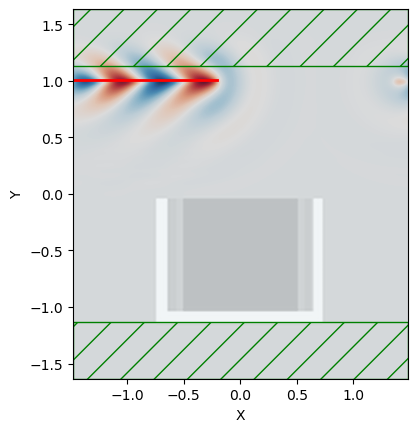

In [236]:
# opt.plot2D(True)
opt.sim.run(until = 1)
opt.sim.plot2D(fields = mp.Ez)

In [203]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [204]:
layer_num = 1
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)


In [205]:
import os
import imageio

n = Nx * layer_num
np.random.seed(5)
# x = 0.4 + 0.2 * np.random.rand(n)  
x = np.ones(n)*0.5

frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)

# 저장된 프레임 파일명 리스트
frame_files = []

cur_beta = 5

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    f0_list = []
    dJ_list = []
    for i in range(len(opt_list)):
        f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
        f0_list.append(f0_i.flatten())
        dJ_list.append(dJ_i)

    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.abs(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        # FoM 기준 변화율 계산 (여기 부분 계속 수정중)
        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.003 and change2 < 0.003) and (bin_change1 < 0.001 and bin_change2 < 0.00075):
            if beta < 8:
                beta *= 1.3
            else:
                beta = beta + 5*np.tanh((beta - 0.5)*0.03)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")

    print(f"Binarization degree: {bin_deg:.4f}")
    fig = plt.figure(figsize=(3, 2))

    ax = plt.gca()
    opt_list[0].plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    # 2) 프레임으로 저장하기
    frame_filename = os.path.join(frames_dir, f"frame_{cur_iter[0]:03d}.png")
    fig.savefig(frame_filename, dpi=150, bbox_inches='tight')
    plt.close(fig)
    frame_files.append(frame_filename)

    return v_new, beta

mp.verbosity(0)
Max_iter = 30

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.95:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        print("FOM increases : ", )
        break




--- Iter 1 ---


NameError: name 'opt_list' is not defined

In [206]:
def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    # (참고) 필요 없다면 rho_list는 삭제 가능
    # rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    # --- 단일 opt 호출로 FoM, gradient 계산 ---
    f0, dJ = opt([rho_full], need_value=True, need_gradient=True, beta=beta)

    # 리스트 형태 유지(나중 평균/변화율 계산 로직 그대로 쓰려고)
    f_vals = [float(np.abs(f0).item())]
    evaluation_history.append(f_vals)

    # dJ_total 은 바로 dJ 사용(평균 불필요)
    dJ_total = dJ
    dJ_flat  = np.asarray(dJ_total).ravel()

    # 체인룰로 design 변수 그레이디언트
    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    # 레이어별로 나눠서 Adam 업데이트
    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    beta_history.append(beta)
    cur_iter[0] += 1

    # --- β 업데이트 로직 그대로 유지 ---
    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.003 and change2 < 0.003) and (bin_change1 < 0.001 and bin_change2 < 0.00075):
            if beta < 8:
                beta *= 1.3
            else:
                beta = beta + 5*np.tanh((beta - 0.5)*0.03)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")
    print(f"Binarization degree: {bin_deg:.4f}")

    # --- 시각화: opt_list[0] → opt 로 변경 ---
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    opt.plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    frame_filename = os.path.join(frames_dir, f"frame_{cur_iter[0]:03d}.png")
    fig.savefig(frame_filename, dpi=150, bbox_inches='tight')
    plt.close(fig)
    frame_files.append(frame_filename)

    return v_new, beta

mp.verbosity(0)
Max_iter = 30

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.95:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        print("FOM increases : ", )
        break


--- Iter 1 ---
Starting forward run...
Starting adjoint run...


TypeError: must be real number, not ArrayBox